In [1]:
"""

Script of petro-inversion of gravity over TKC

Notes:
This version of the script uses data with less noises
but still invert with a higher assumed noise level.
This is equivalent to increase the chi-factor.
This has been needed in order to fit both geophysical
and petrophysical data set.
"""

# Script of petro-inversion of gravity over TKC
import SimPEG.PF as PF
from SimPEG import *
from SimPEG.Utils import io_utils
import matplotlib
import time as tm
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import NearestNDInterpolator
from sklearn.mixture import GaussianMixture
import numpy as np
import copy
import pickle
from pymatsolver import PardisoSolver
%matplotlib inline
matplotlib.rcParams['font.size'] = 14
import seaborn
import sys
sys.path.append('../../../')
from DO27_Utils import *

# Nicer plots
seaborn.set()
# Reproducible Science
np.random.seed(518936)

# We first need to create a susceptibility model.
# Based on a set of parametric surfaces representing TKC,
# we use VTK to discretize the 3-D space.

# Reproducible Science
np.random.seed(518936)

# We first need to create a susceptibility model.
# Based on a set of parametric surfaces representing TKC,
# we use VTK to discretize the 3-D space.

mesh = Mesh.load_mesh('../../../Forward/mesh_inverse')

# Define no-data-value
ndv = -100

# Define survey flight height
Z_bird = 2.

# Load topography file in UBC format and find the active cells
# Import Topo
model_dir = '../../../Geology_Surfaces/'
topofile = model_dir + 'TKCtopo.dat'
topo = np.genfromtxt(topofile, skip_header=1)
# Find the active cells
actv = Utils.surface2ind_topo(mesh, topo, gridLoc='N')
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, ndv)
print("Active cells created from topography!")

# Load data
survey = io_utils.readUBCgravityObservations(
    "../../../Forward/GRAV_noisydata.obs"
)

# Now that we have a survey we can build the linear system ...
nactv = np.int(np.sum(actv))
# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=nactv)
# Create the forward model operator
prob = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap, actInd=actv)
# Pair the survey and problem
survey.pair(prob)

# If you formed the sensitivity gravity matrix before, you can load it here
#G = np.load('../../../Forward/G_Grav_Inverse.npy')
#prob._G = G

# Define noise level
std = 0.01
eps = 0.
survey.std = std
survey.eps = eps

# **Inverse problem**

# Petro Inversion

# It is potential fields, so we will need to push the inverison down
# Create sensitivity weights from our linera forward operator
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr / np.max(wr))

m0 = np.ones(idenMap.nP) * -1e-4

# Load ground-truth for comparison
mesh = Mesh.load_mesh('../../../Forward/mesh_inverse')
model_grav = mesh.readModelUBC(
    '../../../Forward/model_grav.den'
)
geomodel = mesh.readModelUBC(
    '../../../Forward/geomodel'
) 
model_grav = model_grav[model_grav != -100.]

# Load petrophysics
clf = pickle.load(open('../../../Petrophysics/gmm_density_PK.p', 'rb'))
n = clf.n_components

# PGI Regularization
wires = Maps.Wires(('m', m0.shape[0]))
reg = Regularization.MakeSimplePetroRegularization(
    GMmref=clf,
    GMmodel=clf,
    mesh=mesh,
    wiresmap=wires,
    maplist=[idenMap],
    mref=m0,
    indActive=actv,
    alpha_s=1.0, alpha_x=1.0, alpha_y=1.0, alpha_z=1.0,
    alpha_xx=0., alpha_yy=0., alpha_zz=0.,
    cell_weights_list=[wr]
)
reg.mrefInSmooth = False
reg.approx_gradient = True
reg.objfcts[0].evaltype = 'approx'

# Data misfit
dmis = DataMisfit.l2_DataMisfit(survey)
# Assign flat uncertainties of 0.01mGal
wd = np.ones(len(survey.dobs)) * 0.01
dmis.W = 1 / wd

# Optimization scheme
opt = Optimization.ProjectedGNCG(
    maxIter=30, lower=-2., upper=0., maxIterLS=20, maxIterCG=100, tolCG=1e-4
)
opt.tolF = 1e-2
opt.tolG = 1e-2
opt.tolX = 1e-2
# Create inverse problem
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

# Add directives to the inversion

# Smoothness weights  estimation
Alphas = Directives.AlphasSmoothEstimate_ByEig(
    alpha0_ratio=0.5,
    ninit=10, verbose=True
)
# Beta initialization
beta = Directives.BetaEstimate_ByEig(beta0_ratio=1., ninit=10)

# Beta Schedule
betaIt = Directives.PetroBetaReWeighting(
    verbose=True, rateCooling=5., rateWarming=1.,
    tolerance=0.1, UpdateRate=1,
    ratio_in_cooling=False,
    progress=0.2,
    update_prior_confidence=False,
    progress_gamma_cooling=1.,
    ratio_in_gamma_cooling=False,
    alphadir_rateCooling=1.,
    kappa_rateCooling=1.,
    nu_rateCooling=1.,
)

# Targets misfits
targets = Directives.PetroTargetMisfit(verbose=True)
MrefInSmooth = Directives.AddMrefInSmooth(
    wait_till_stable=True,
    verbose=True
)

# Update GMM, mref and Ws
petrodir = Directives.GaussianMixtureUpdateModel(
    keep_ref_fixed_in_Smooth=True,
    verbose=False,
    nu=1e8,
    kappa=1e8,
    alphadir=1e8
)

# Pre-conditioner
update_Jacobi = Directives.UpdatePreconditioner()

# Create inversion
inv = Inversion.BaseInversion(
    invProb,
    directiveList=[
        Alphas, beta,
        petrodir, targets,
        betaIt, MrefInSmooth, update_Jacobi
    ]
)

Active cells created from topography!
Begin linear forward calculation: 
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Linear forward calculation ended in: 1347.7770414352417 sec


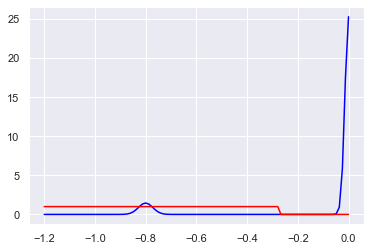

In [2]:
vmin, vmax = -1.2,0
plt.plot(
     np.linspace(vmin, vmax, 100), np.exp(
         clf.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='blue'
)
plt.plot(
     np.linspace(vmin, vmax, 100), (
         clf.predict(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='red'
)
#plt.gca().set_ylim([-10.,10.])
plt.show()

In [3]:
# Run inversion...
mcluster = inv.run(m0)


                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
Alpha scales:  [1, 1]
Alpha scales:  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Alpha scales:  [0.0, 6436.967081679338, 6418.893111252958, 6415.428171608268]
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.53e+01  4.31e+06  0.00e+00  4.31e+06    1.22e+03      0              
DM:  [958991.75489598] [False] ; CL:  1493629.3022643193 False ; DP:  True ; All: False
progress [958991.75489598] >< [3451606.67703696]
mref changes in  0  places
   1  1.53e+01  9.59e+05  4.28e+04  1.61e+06    9.55e+01      0              
DM:  [966760.43976796] [False] ; CL:  1471297.607

In [4]:
# Get the final model back to full space
m_petro = actvMap * mcluster
m_petro[m_petro == ndv] = np.nan


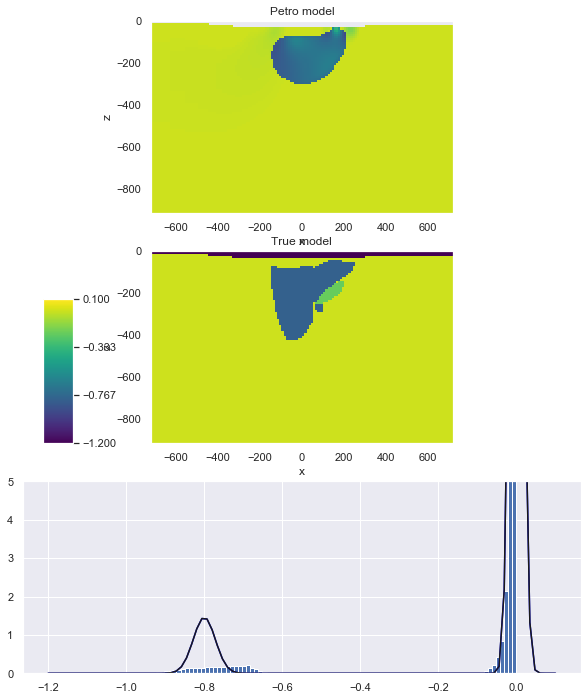

In [5]:
# Plot the recoverd models
mesh = Mesh.TensorMesh([mesh.hx, mesh.hy, mesh.hz], x0="CCN")
npad = 10
X, Y = np.meshgrid(mesh.vectorCCx[npad:-npad:2], mesh.vectorCCy[npad:-npad:2])

vmin, vmax = -1.2, 0.1
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
ax = Utils.mkvc(ax)
mesh.plotSlice(
    m_petro, ax=ax[0], normal='Y',
    clim=np.r_[vmin, vmax], pcolorOpts={'cmap':'viridis'}
)
ax[0].set_aspect('equal')
ax[0].set_title('Petro model')

model_grav = mesh.readModelUBC(
    '../../../Forward/model_grav.den'
)
dat_true = mesh.plotSlice(
    model_grav, ax=ax[1], normal='Y',
    clim=np.r_[vmin, vmax], pcolorOpts={'cmap':'viridis'}
)
ax[1].set_aspect('equal')
ax[1].set_title('True model')

pos = ax[1].get_position()
cbarax = fig.add_axes(
    [pos.x0 - 0.15, pos.y0,  pos.width * 0.1, pos.height * 0.75]
)  # the parameters are the specified position you set
cb = fig.colorbar(
    dat_true[0], cax=cbarax, orientation="vertical",
    ax=ax[1], ticks=np.linspace(vmin, vmax, 4)
)
mcluster = m_petro[~np.isnan(m_petro)]
ax[2].hist(mcluster, bins=100, density=True)
ax[2].plot(
    np.linspace(vmin, vmax, 100), np.exp(
        clf.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
    ),
    color='blue'
)
ax[2].plot(
    np.linspace(vmin, vmax, 100), np.exp(
        reg.objfcts[0].GMmodel.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
    ),
    color='k'
)
ax[2].set_ylim([0., 5.])

plt.show()
